# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [8]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
import sys

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)
import keras
import keras_utils
from keras_utils import reset_tf_session

# Examine the data

We have 50000 28x28 images of digits from 0 to 9 sourced from MNIST.
We will train a classifier on this data.

In [2]:
import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset()

X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A cross-section of a sample patch:


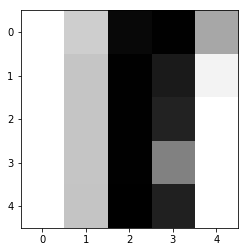

An entire sample:


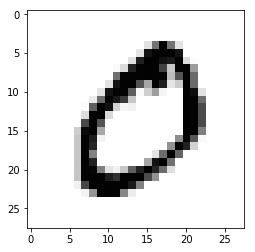

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [3]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A cross-section of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()

print("An entire sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()

print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

The task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

Will need to first calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

Use cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [4]:
# Flatten the images (28x28 -> 784) to simplify linear model
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [5]:
# Convert y_train to one-hot encoded vectors for cross-entropy
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [6]:
# Re-run this as required to rebuild the graph
s = reset_tf_session()

In [7]:
# Initialize Weights and bias'
W = tf.get_variable("W", shape=(784, 10), dtype=tf.float32) # shape[0] = 784
b = tf.get_variable("b", shape=(10,), dtype=tf.float32)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# Placeholders for the input data
input_X = tf.placeholder("float32", shape=(None,784))
input_y = tf.placeholder("float32", shape=(None,10))# tf.placeholder(...) for one-hot encoded true labels

In [9]:
# Compute predictions
# Resulting shape should be [input_X.shape[0], 10]
logits = input_X @ W + b
probas = tf.nn.softmax(logits)
# apply tf.argmax to find a class index with highest probability
classes = tf.argmax(probas, axis=1)

# Average loss over all the objects with tf.reduce_mean() to produce scalar
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=input_y))

# Use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [10]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# Logging the progress right here in Jupyter (Also examine in TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

# Finish an epoch when we've looked at all training samples
for epoch in range(EPOCHS):
    
    batch_losses = []
    # Note: Data is already shuffled
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # Collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    # This part is usually small
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})
    # This is slow and usually skipped
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))
    
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvPfjt%2B1J8FP2b5NGsfil4g1Maj4ilnTQNB8OeF9R1zVNR8lVed4bHTbee5kjiVkMkixlI96biu5c%2BhV4N%2B0P8D/j5/wANJ%2BDv2tv2bLLwfrWueH/B2seFNX8KeOdcutLtLywv7mwuxcQXtraXj288U2noCpt3WVJSCUKK1ABpf/BTL9izWLvxPb2nxXv0h8FWsk/jLUrvwXrEFjoIS0iu9l5dy2iwWsrQzRskMjrJIWKorMrKL2n/APBQ/wDZK1HwBrXxFTx/q9vB4f1ay0vVdE1DwNrNrrkV5ebfscC6PNaLqEr3AYGER27eaAxTcFYjy2b9gH4y%2BMf2a/jn8NfGHinwppHin4o/FS38daHc6U1xeWFpeW0OiywQ3IkihkkiN3pRRwoyYHGDuJVaPi79i/8AaV%2BLmr/Ef45fG34S/CjWvFnjWx8KaPp/gKy%2BI2s2Wm6fY6Hcaldw3qa7b6al5DqDXOqTOksVoPJSKNFZiWcgHsviH9vv9mzwv4a8OeI9XvvG3meK0v5NE8P2vwm8SXGuSRWUscV3NJpMWntf28MLzQq8s0CIpmiy37xM%2Bmaz8RPBHhv4e3XxX8T%2BJbbSvDljo76rf6vqrfZYbSySIzPPMZdvlKsYLNvxtAOcYNfGHin9hH9s/WPgX4X8Nay3hfxV470a58RHRfGV/wDHbxNpGr%2BCLW%2BuUktLO11q1sJLzXIYkjhEy3qw/aTbReYCFGPUfjR/wTotfj1%2Bzb4n%2BHHxD%2BOfjW78d%2BMPhfH4Z17xS3jbWho818tpDE2oJoS3y2FuzzQLK3kRRSEPIBIrSM5AOkg/4KUfsZf8K58V/FbWPite6Jo3giysr7xQ/ifwdq%2Bk3NlZXkxhtb37LeWsVxJaSyK6pcxxtC3luQ%2BEYjj/AI3f8FZP2d/hn8ENU%2BMfgPRfFXiqbQfiD4X8L674Y/4QXXbHU7A6zqVrax3T2cmnNdeV5Fw88DeT5d48aW8MhknjB8r1T/gmJ8ZPHfwq8faR4i8DeG9G8Y%2BI9D0fR7DxDqv7RfjPxut3aWusW%2BoTRyf27AfsEZ8likUSzHe%2BGkxknv8A9qH9gz40/GD4g/F/4g%2BBfEPheOTxfB8LbzwlZ6tfXMSvf%2BE/EdzrUsN40dvJ5ENwGt4VljEzrl2MfyKrgHqFh/wUE/Zb1H4m2XwZh8T%2BJo/Fd5oun6xLoF38N9egudO0%2B9adILu/SSyU6dDut5VeS68pYiFEhQum6j4a/wCCmH7FPi3wZ4s%2BIWkfGC4TR/Bfgi68Zaxe6h4S1W0Fx4et0Z5tWsVntUbVLNVQ4nsxPGxZArEugbB0P9kP4ofEP4mfG74g/G9fD2gxfGj4O%2BHfCF1Y%2BE9duNRl0u4tE11Ltlnns7XzYwNViMT7FZikm6OPA3fN37Y37Kn7UOj/ALDHxS%2BJv7TF34AtIfhD%2BxT8QfBHhePwFqF5cNrzXukWxn1G6W5toBYqE0i3CWcbXAVppCZ22oKAPrPw9/wUl/Yy8TaHrHiPT/i1dQWehppU1/JqnhLVbJmtNSu1s7HUIUuLVGubCWdgovoQ9qoDO0qorMPT9E%2BLvw88R/FLX/gvofiH7T4k8LaXp%2Boa/YR2k22zgvmuBa7pinlF3%2ByzHy1cyKoRmVVkjLfJOofsz%2BIPFegeKfjb/wAFIvF/wz8J%2BBbf9nu5%2BHUlx4f8QTLay6beyQyXmq3k17BbpYOTBbCG2QzCAmT/AEiQsuOw/wCCPngP4u2f7I9r8f8A9pDUDf8AxJ%2BL15H4n8V6g9nJbtJCLSCy01fKl%2BeH/iX2lpI0TYKSzTZAYtkA%2BqqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8R0j/AIKMfse6ld69Z6n8Urzw83hzw5c%2BINQk8a%2BEdV0GObSbd0jnv7WTUrWBb63R5IlaW2MqAyxjOXXPtN7FczWcsNndCCZ4mWKYx7/LYjhtp64POO9fmJq//BHL9uX4v6t4X1z43fHHQ31vw14P1Cz1DxRqHxW8TeJx4h1v7ZpV9a6idLvoobLSbaS50xfPsLIBRHJtWWQKgUA%2B2X/b/wD2YbX4aN8WNY8QeKtK0ttcg0axs9c%2BGWv2GqanfzIZIYLLTbixS9v2kQM6/Z4ZAyo7AkIxHReA/wBqz4H/ABH1%2By8J%2BHPEOqQ6vf8AhSfxJDpGteFdS0y7TTYbv7JLLLDeW8UkDrP8hhkVZe%2BzbzXk3xO%2BDn7bvxib4e/G3XPBvwq0P4h/Cjx1NrHh/wAM2vjjUr/Rdcs7jSbvTLmO4vn0qGaxmKXskkbpa3AjMQU%2BYJGxV%2BJPwG/bg1/4y%2BHf2mvA%2BjfCu08WX3ww1XwX4x0LUvFepSWGkLcX8N1a39lcJpwk1AxCN1kt5YrQSlxiWLHIB3Gk/wDBRv8AZA8R694F8LeFfiNqus6n8SfBuleLfBunaJ4H1m9nvND1F9lrqMiQWjNa2%2B7HmSTiNbcMpm8oMCdj4a/tufs3fFf4jXPwn8M%2BL9Ws9ft9LudThsvE/gzVtEW/sbeRI57uyl1G1gjv4I3liDy2zSIvmISQGUnyj9hT9hL4sfsw6/8ADjWfHniDw1dnwd%2Byl4R%2BGN%2B%2BkXM8rNq2lvM1zNF5kEe61bemxmKu235o0wK8a%2BGn/BKv9sbxP8UfC/ib9qb4w2eqRaf4A8V%2BF/GniaD4v%2BJNavPEUur2KW39p2umX0Men6EcqWNpaKUXKgTOI1WgD6l8J/8ABRf9kfxrosfirQfHeuf2Hcarpen6f4lvfh/rdrpWoy6lex2VlJaX09mlteQS3M0UYuIJHhBlQs4VgT6X4W%2BLvw88a/EDxT8LvC/iH7XrnguSzj8T2iWkwWxkuoPtEEZlZBG7tCVkKIzMiyRlgokTd8w%2BOPAnxF8K/wDBPbxp8CP%2BChnif4VeCPAWg/DSLQLb4meHfFt2GadI0trXUntLqzgTTZlmFvJDBHcXTGcoiOTtDdr/AMEr/h98WPDf7ImlfFX9oqwS3%2BJ3xYvpfHXxEhW3aL7Pf36xmG02N8yfZbGOys9pyQLXBoA%2BjaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAC

# Adding more layers

Add a few hidden layers and see how that improves validation accuracy.

Previously we've coded a dense layer with matrix multiplication by hand. This is quite inconvenient as we have to create a lot of variables and the code becomes a mess.

In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

This will create all the necessary variables automatically.
Here we can also choose an activation function for the hidden layer.

Add 2 hidden layers aiming for ~0.97 validation accuracy here.

In [11]:
hidden1 = tf.layers.dense(input_X, 256, activation=tf.nn.sigmoid)
hidden2 = tf.layers.dense(hidden1, 256, activation=tf.nn.sigmoid)

# Compute predictions
logits = tf.layers.dense(hidden2, 10)
probas = tf.nn.softmax(logits)
# Apply tf.argmax to find a class index with highest probability
classes = tf.argmax(probas, axis=1)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=input_y))
step = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:
Use keras.layers.dense instead.
